**Import Necessary Modules**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding
import umap.umap_ as umap

**Load and Preprocessing MNIST**

In [2]:
(trainX, trainY), _ = mnist.load_data()
trainX = trainX.astype("float32") / 255.0

def preprocess_images_batch(images, batch_size=500):
    resized = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        batch = tf.expand_dims(batch, -1)           # (28,28) -> (28,28,1)
        batch = tf.image.resize(batch, (224, 224)) # resize to 224x224
        batch = tf.image.grayscale_to_rgb(batch)   # (224,224,1) -> (224,224,3)
        resized.append(batch)
    return tf.concat(resized, axis=0).numpy()

x_subset = preprocess_images_batch(trainX[:2000])
y_subset = trainY[:2000]
y_subset_cat = to_categorical(y_subset, num_classes=10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Load MobileNetV2 pretrained (feature extraction BEFORE fine-tuning)**

In [3]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
base_model.trainable = False

feature_extractor_before = Model(inputs=base_model.input, outputs=base_model.output)
features_before = feature_extractor_before.predict(x_subset, batch_size=64, verbose=1)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step


**Fine Tuning**

In [4]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.Dense(128, activation='relu', name="features")(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune on subset
x_train_small = preprocess_images_batch(trainX[:5000])
y_train_small = to_categorical(trainY[:5000], num_classes=10)

model.fit(x_train_small, y_train_small, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 233s 3s/step - accuracy: 0.6627 - loss: 1.0571 - val_accuracy: 0.9080 - val_loss: 0.2731
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.9552 - loss: 0.1825 - val_accuracy: 0.9420 - val_loss: 0.1869
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.9687 - loss: 0.1168 - val_accuracy: 0.9460 - val_loss: 0.1747
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - accuracy: 0.9815 - loss: 0.0796 - val_accuracy: 0.9520 - val_loss: 0.1683
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.9828 - loss: 0.0645 - val_accuracy: 0.9720 - val_loss: 0.1411
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step - accuracy: 0.9933 - loss: 0.0416 - val_accuracy: 0.9720 - val_loss: 0.1475
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.9946 - loss: 0.0313 - val_accuracy: 0.9560 - val_loss: 0.1465
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.9938 - loss: 0.0274 - val_accuracy: 0.9720 - v

In [5]:
feature_extractor_after = Model(inputs=model.input, outputs=model.get_layer("features").output)
features_after = feature_extractor_after.predict(x_subset, batch_size=64, verbose=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step


**Extract Features After Fine-tuning from intermediate Dense layer**

In [6]:
feature_extractor_after = Model(inputs=model.input, outputs=model.get_layer("features").output)
features_after = feature_extractor_after.predict(x_subset, batch_size=64, verbose=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step


**VIsualization and Plots(PCA,t-SNE,UMAP)**

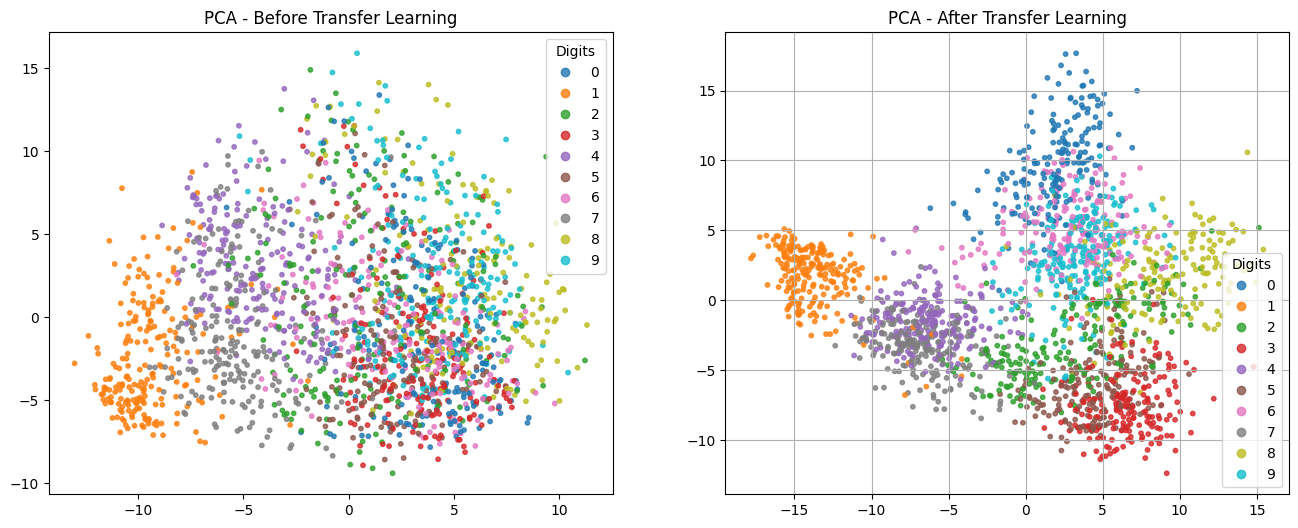

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


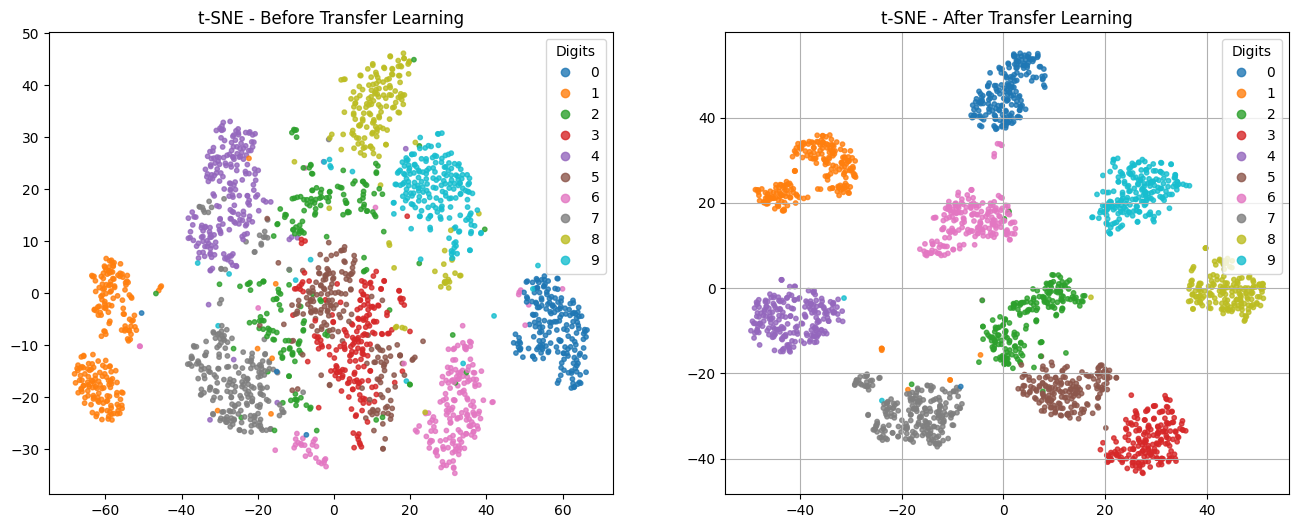

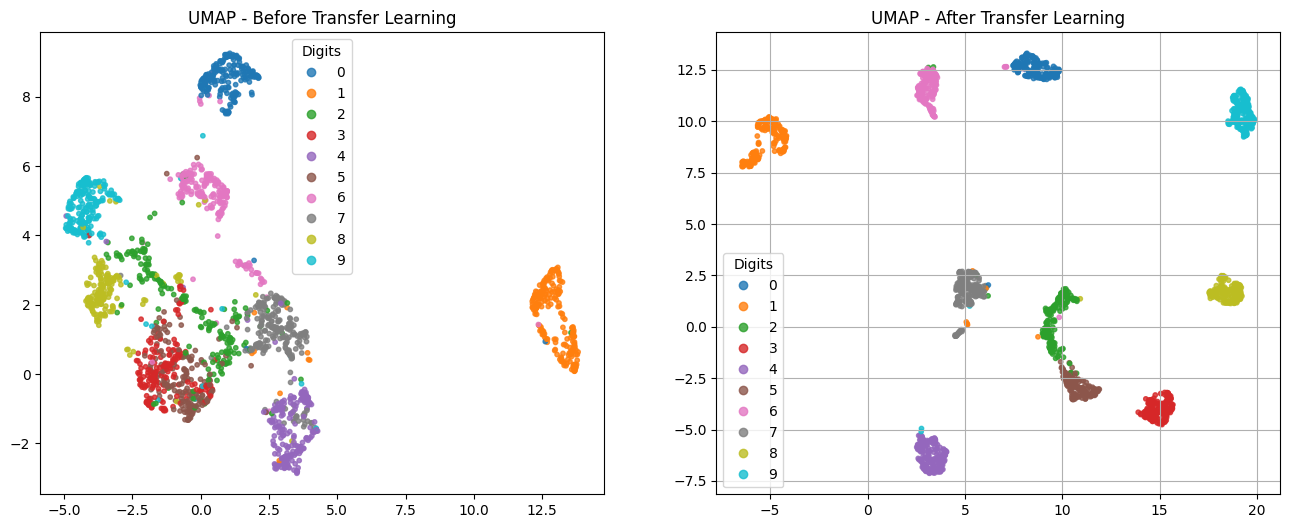

In [7]:
def plot_2d(X_before, y_before, X_after, y_after, title_before, title_after):
    plt.figure(figsize=(16, 6))

    plt.subplot(1,2,1)
    scatter = plt.scatter(X_before[:, 0], X_before[:, 1], c=y_before, cmap='tab10', s=10, alpha=0.8)
    plt.legend(*scatter.legend_elements(), title="Digits", loc='best')
    plt.title(title_before)

    plt.subplot(1,2,2)
    scatter = plt.scatter(X_after[:, 0], X_after[:, 1], c=y_after, cmap='tab10', s=10, alpha=0.8)
    plt.legend(*scatter.legend_elements(), title="Digits", loc='best')
    plt.title(title_after)

    plt.grid(True)
    plt.show()

# PCA
pca = PCA(n_components=2)
pca_before = pca.fit_transform(features_before)
pca_after = pca.fit_transform(features_after)
plot_2d(pca_before, y_subset, pca_after, y_subset, "PCA - Before Transfer Learning", "PCA - After Transfer Learning")


# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
tsne_before = tsne.fit_transform(features_before)
tsne_after = tsne.fit_transform(features_after)
plot_2d(tsne_before, y_subset, tsne_after, y_subset, "t-SNE - Before Transfer Learning", "t-SNE - After Transfer Learning")

# UMAP
umap_model = umap.UMAP(n_components=2)
umap_before = umap_model.fit_transform(features_before)
umap_after = umap_model.fit_transform(features_after)
plot_2d(umap_before, y_subset, umap_after, y_subset, "UMAP - Before Transfer Learning", "UMAP - After Transfer Learning")
